
Training SimpleRNN model...


Epoch 1/50

819/819 [==============================] - 2s 1ms/step - loss: 0.0256
Epoch 2/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 3/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 4/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 5/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 6/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 7/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 8/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0047
Epoch 9/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0047
Epoch 10/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 11/50
819/819 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 12/50
819/819 [==============================] - 1s 1ms/step - loss: 

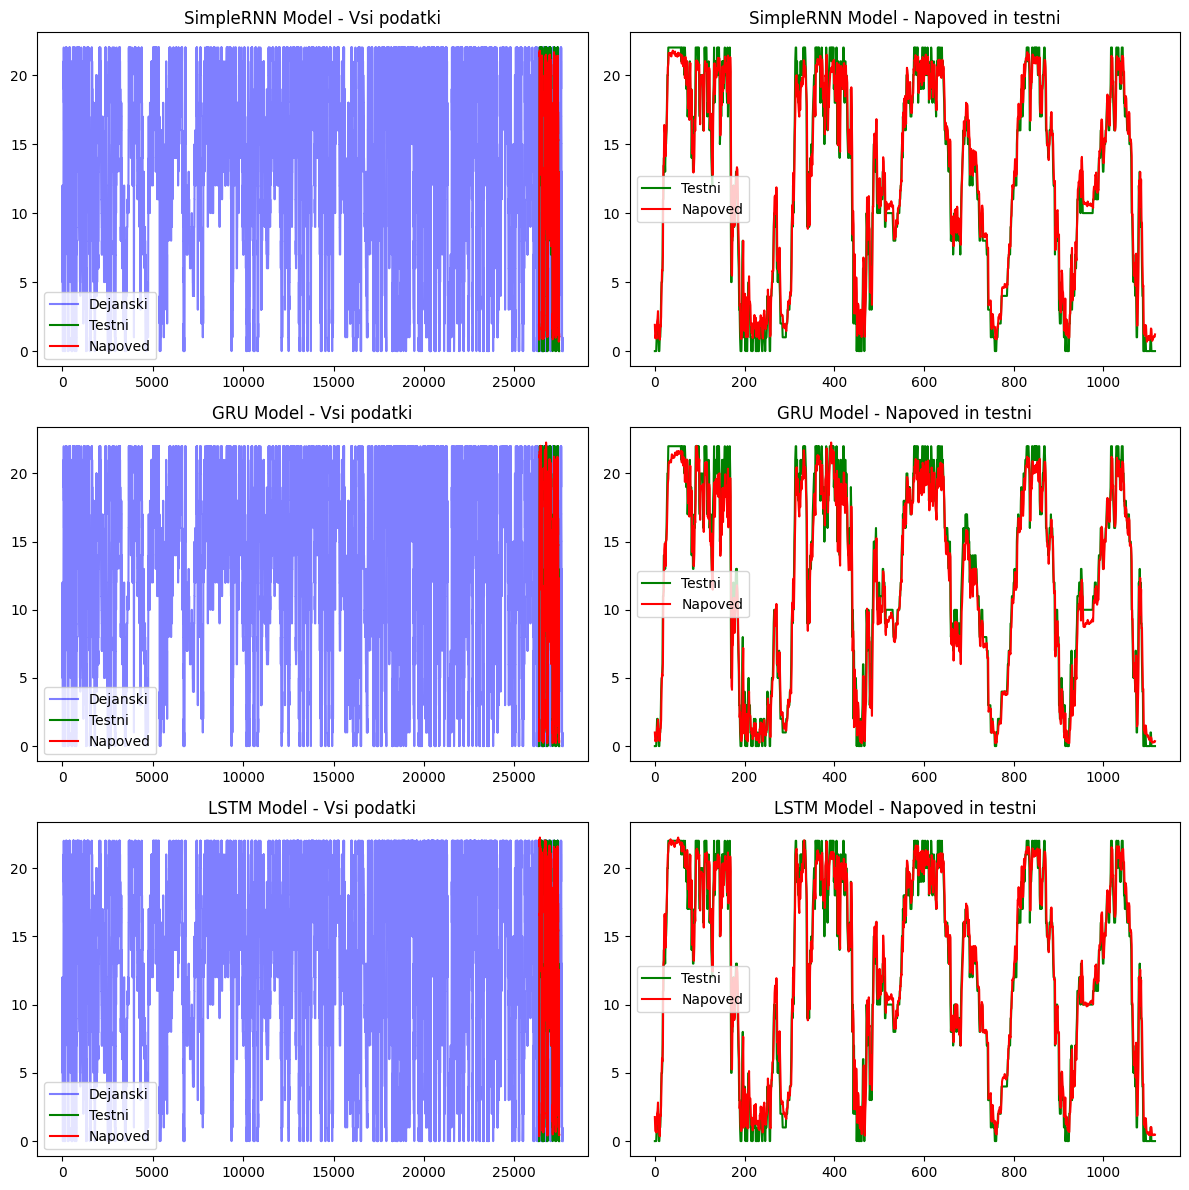

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


data = pd.read_csv('mbajk.csv')

data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True)
data.set_index('date', inplace=True)
data = data[['available_bike_stands']]
data_array = data.values.astype(float)


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)
train_size = len(data_scaled) - 1302
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)


window_size = 186
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)


X_train = X_train.reshape(-1, 1, window_size)
X_test = X_test.reshape(-1, 1, window_size)

def build_model(model_type):
    model = keras.Sequential()
    if model_type == 'SimpleRNN':
        model.add(keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.SimpleRNN(32))
    elif model_type == 'GRU':
        model.add(keras.layers.GRU(32, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.GRU(32))
    elif model_type == 'LSTM':
        model.add(keras.layers.LSTM(32, return_sequences=True, input_shape=(1, window_size)))
        model.add(keras.layers.LSTM(32))
    
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1))
    return model

models = {}
histories = {}
predictions = {}
for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
    print(f"Training {model_type} model...")
    model = build_model(model_type)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=50, verbose=1)
    models[model_type] = model
    histories[model_type] = history
    predictions[model_type] = model.predict(X_test)

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1))

num_models = len(models)
fig, axes = plt.subplots(num_models, 2, figsize=(12, num_models * 4))

for i, (model_type, model) in enumerate(models.items()):
    pred_original = inverse_transform(scaler, predictions[model_type])
    y_test_original = inverse_transform(scaler, y_test)
    full_data_original = inverse_transform(scaler, data_scaled)

    mse = mean_squared_error(y_test_original, pred_original)
    mae = mean_absolute_error(y_test_original, pred_original)
    rmse = np.sqrt(mse)
    axes[i, 0].plot(full_data_original, label='Dejanski', color='blue', alpha=0.5)
    axes[i, 0].plot(range(train_size, train_size + len(y_test_original)), y_test_original, label='Testni', color='green')
    axes[i, 0].plot(range(train_size, train_size + len(pred_original)), pred_original, label='Napoved', color='red')
    axes[i, 0].set_title(f'{model_type} Model - Vsi podatki')
    axes[i, 0].legend()

    axes[i, 1].plot(y_test_original, label='Testni', color='green')
    axes[i, 1].plot(pred_original, label='Napoved', color='red')
    axes[i, 1].set_title(f'{model_type} Model - Napoved in testni')
    axes[i, 1].legend()

    print(f"Model: {model_type}")
    print(f"MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}\n")

plt.tight_layout()
plt.show()
